In [1]:
import sys, platform, os

base_path = '/home/yurid/git/tcc'

if platform.system() == 'Darwin':
    base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

from math import sqrt
import keras
import numpy as np
import pandas as pd
import optuna
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.impute import KNNImputer
from datetime import date, datetime
import src.filler as fl
from src.filler import Debbuger
from src.dataframe import read_data_from_csv, show_error_metrics, split_data, windowing_nparray, windowing
from src.scaler import Scaler
from src.model import load_from_cache, save_trained_model

2023-11-24 21:29:09.698763: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 21:29:16.266775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yurid/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def agg_fill(df, filler_method):
    dict_index = {}
    df_temp = df.copy().resample('D').mean()
    for c in df_temp:
        dict_index[c] = df_temp[c].loc[np.isnan(df_temp[c].values)].index
    
    df = filler_method(df)

    df = agg(df)

    for c in df:
        df[c].loc[dict_index[c]] = pd.NA

    return df.loc[df.index >= df[(~df.RADIATION.isna()) & (~df.TEMP.isna()) & (~df.HUMIDITY_h.isna())].index[0]]

def agg(df):
    return df[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
        .resample('D') \
        .agg({'RADIATION': 'sum', 'TEMP': 'mean', 'HUMIDITY_h': 'mean'})\
        .replace(0, np.nan)


def get_dataframe(key, filename, filler_method, filler_before_agg=False, base_path='./cache'):
    file_cached = f'{base_path}/data/{key}.csv'
    
    if os.path.isfile(file_cached):
        return pd.read_csv(
            file_cached,
            sep=',',
            parse_dates=['Timestamp'],
            index_col=['Timestamp'])
    
    df = pd.read_csv(
        filename,
        sep=',',
        parse_dates=['Timestamp'],
        index_col=['Timestamp']).replace(0, np.nan)

    df = df[['RADIATION', 'TEMP', 'HUMIDITY_h']]
    df = df.loc[df.index >= df[(~df.RADIATION.isna()) & (~df.TEMP.isna()) & (~df.HUMIDITY_h.isna())].index[0]]

    if filler_before_agg:
        #df = agg_fill(df, filler_method)
        df = filler_method(df)
        df = agg(df)
    else:
        df = agg(df)
        df = filler_method(df)

    print(df.isna().sum())
    df.to_csv(file_cached)
    return df


def train_model(key,
                model, 
                train_x, 
                train_y, 
                cache_path,
                is_debug=False,
                batch_size=16,
                validation_split=0.2,
                use_cache=False):
    
    from_cache = use_cache
    cache_path = f'{cache_path}/models'

    if from_cache:
        exist_cache, loaded_model = load_from_cache(key, cache_path)
        from_cache = exist_cache

    if from_cache and loaded_model is not None:
        loaded_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam())
        return loaded_model


    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(learning_rate=0.002003477629970563))

    Debbuger.log(is_debug, train_x.shape, train_y.shape)
    Debbuger.log(is_debug, 'Model Summary', model.summary())

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)

    history = model.fit(train_x,
                        train_y,
                        epochs=5000,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=1,
                        callbacks=[es],
                        workers=4,
                        use_multiprocessing=True)

    # plot history
    if is_debug:
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()

    if use_cache:
        save_trained_model(key, model, cache_path)

    return model


def create_folder_cache(base_path):
    if not os.path.exists(f'{base_path}/data'):
        os.makedirs(f'{base_path}/data')
    if not os.path.exists(f'{base_path}/models'):
        os.makedirs(f'{base_path}/models')




In [3]:
def forecast(key, 
             filename, 
             filler_method, 
             model_config, 
             train_ratio=0.9,
             step_back=5,
             filler_before_agg=False, 
             use_cache=False,
             is_debug=False,
             base_path='./cache'):
    base_path = base_path + f'/{key}'
    create_folder_cache(base_path)

    df = get_dataframe(key, filename, filler_method, filler_before_agg, base_path)

    scaler = Scaler(df, (0,1))
    df_scaled = scaler.get_dataframe_scaled()
    X, Y = windowing(df_scaled, predict_column='RADIATION', step_back=step_back, step_front=1)
    train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=train_ratio)

    model = train_model(key, 
                        model_config, 
                        train_x, 
                        train_y,        
                        base_path, 
                        use_cache=use_cache, 
                        is_debug=True)

    predict = model.predict(test_x)
    real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
    predict = scaler.scales['RADIATION'].inverse_transform(predict)

    # Avaliando previsão
    range_plot = 150
    print('Forecasting')
    show_error_metrics(real, predict)
    indice = df.index[-len(real):]
    pyplot.plot(indice[:range_plot], real.reshape(-1,1)[:range_plot], color='blue', label='Real')
    pyplot.plot(indice[:range_plot], predict.reshape(-1,1)[:range_plot], color='red', label='Previsão')
    pyplot.legend()
    pyplot.savefig(f'./img/{key}.svg')
    pyplot.savefig(f'./img/{key}.png')
    pyplot.show()



In [4]:
def linear_interpolate(df):
    data = df.copy()
    for column in df.columns:
        data[column] = df[column]\
            .interpolate(method='linear')\
            .interpolate(method='linear', limit_direction='backward')
        print(f'{column} - {data[column].isna().sum()}')
    return data

def random_forest(df):
    data = df.copy()
    for column in df.columns:
        print(f'{column} - {data[column].isna().sum()}')
        filler_model = fl.RandomForestFillerWithOneModel(
            n_estimators=1500, 
            n_in=3, 
            n_out=1, is_debug=False)
        data[column] = filler_model.filler(data[column])
        print(f'{column} - {data[column].isna().sum()}')
    return data

def random_forest_hourly(df):
    data = df.copy()
    for column in df.columns:
        print(f'{column} - {data[column].isna().sum()}')
        filler_model = fl.RandomForestFillerWithOneModel(
            n_estimators=1500, 
            n_in=10, 
            n_out=1, is_debug=False)
        data[column] = filler_model.filler(data[column])
        print(f'{column} - {data[column].isna().sum()}')
    return data

def dmd(df):
    data = df.copy()
    for column in df.columns:
        filler_model = fl.HodmdFiller(d_factor=0.99)
        data[column] = filler_model.dmd_filler(df[column])
        print(f'{column} - {data[column].isna().sum()}')
    return data

def fillzero(df):
    data = df.copy()
    for column in df.columns:
        data[column] = df[column].fillna(0)
        print(f'{column} - {data[column].isna().sum()}')
    return data



In [5]:
city = 'sao joao del rei'
filename = f'{base_path}/data/daily_{city}.csv'

step_back = 5
model = keras.Sequential([
    Dense(units=1, input_shape=(step_back, 3)),
    LSTM(128),
    Dropout(0.25),
    Dense(1, activation='relu')
])

2023-11-24 21:29:32.146457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-24 21:29:34.170678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-24 21:29:34.170766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-24 21:29:34.178060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-24 21:29:34.178163: I tensorflow/compile

2023-11-24 21:29:54.628442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


19/19 [==============================] - 16s 6ms/step
Forecasting
Test R2: 0.312
Test MSE: 20063422.896
Test RMSE: 4479.221
Test MAE: 3377.879
Test MAPE: 0.252


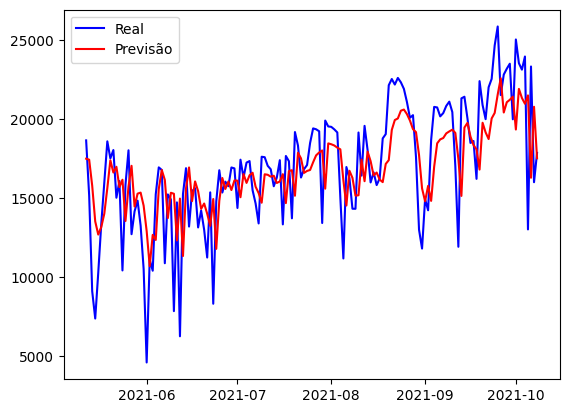

In [6]:
forecast(key=f'{city}_lstm_5_1_with_linear_interpolation_fill_before_agg', 
         filename=filename, 
         model_config=model,
         filler_method=linear_interpolate, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=True)

19/19 [==============================] - 0s 5ms/step
Forecasting
Test R2: 0.283
Test MSE: 19687764.529
Test RMSE: 4437.090
Test MAE: 3344.770
Test MAPE: 0.262


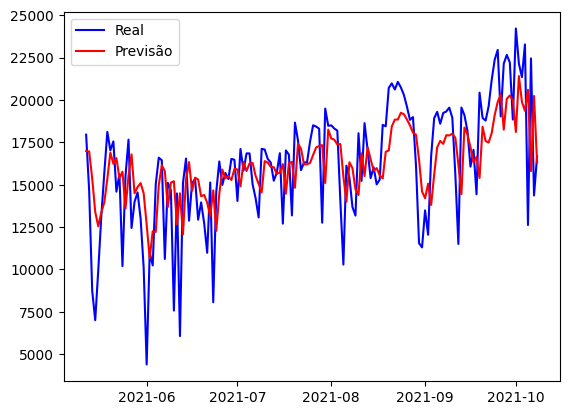

In [7]:
forecast(key=f'{city}_lstm_5_1_with_linear_interpolation', 
         filename=filename, 
         model_config=model,
         filler_method=linear_interpolate, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=False)

In [8]:
# forecast(key=f'{city}_lstm_5_1_with_rf_fill_before_agg', 
#          filename=filename, 
#          model_config=model,
#          filler_method=random_forest_hourly, 
#          step_back=step_back, 
#          use_cache=True, 
#          filler_before_agg=True)

19/19 [==============================] - 0s 5ms/step
Forecasting
Test R2: 0.290
Test MSE: 19485060.653
Test RMSE: 4414.189
Test MAE: 3303.136
Test MAPE: 0.261


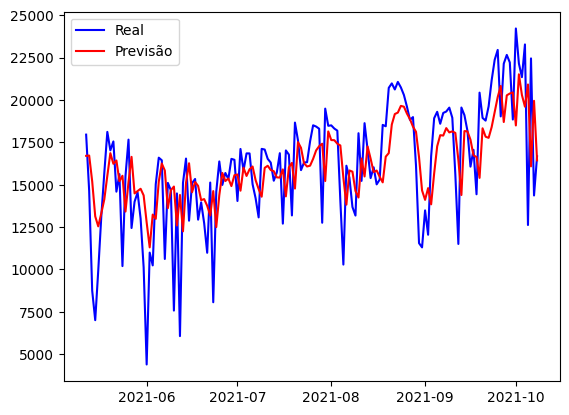

In [9]:
forecast(key=f'{city}_lstm_5_1_with_rf', 
         filename=filename, 
         model_config=model,
         filler_method=random_forest, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=False)

In [10]:
# forecast(key=f'{city}_lstm_5_1_with_dmd_fill_before_agg', 
#          filename=filename, 
#          model_config=model,
#          filler_method=dmd, 
#          step_back=step_back, 
#          use_cache=False, 
#          filler_before_agg=True)

19/19 [==============================] - 0s 5ms/step
Forecasting
Test R2: 0.283
Test MSE: 19688662.341
Test RMSE: 4437.191
Test MAE: 3397.272
Test MAPE: 0.261


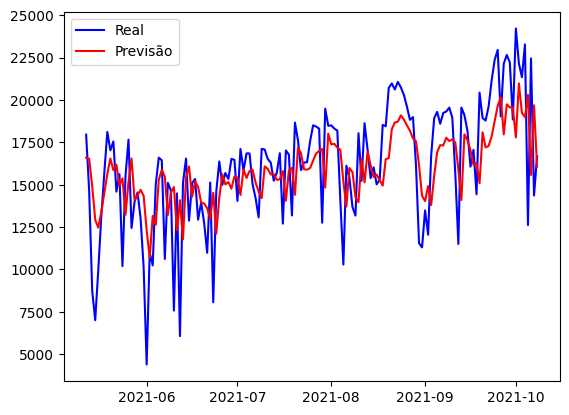

In [11]:
forecast(key=f'{city}_lstm_5_1_with_dmd', 
         filename=filename, 
         model_config=model,
         filler_method=dmd, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=False)

19/19 [==============================] - 1s 6ms/step
Forecasting
Test R2: 0.278
Test MSE: 19834119.882
Test RMSE: 4453.551
Test MAE: 3409.388
Test MAPE: 0.265


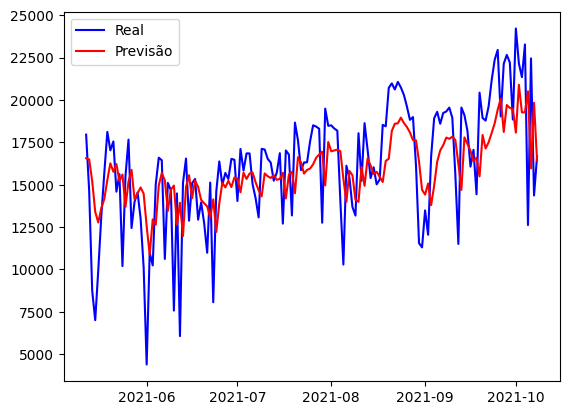

In [12]:
forecast(key=f'{city}_lstm_5_1_with_fillzero', 
         filename=filename, 
         model_config=model,
         filler_method=fillzero, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=False)